In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
class LongitudinalDataSimulator:
    def __init__(self, n_subjects, n_timepoints, treatment_effect_strength, 
                 treatment_intercept=-1, outcome_intercept=-1, censoring_strength=0.5):
        self.n_subjects = n_subjects
        self.n_timepoints = n_timepoints
        self.treatment_effect_strength = treatment_effect_strength
        self.treatment_intercept = treatment_intercept
        self.outcome_intercept = outcome_intercept
        self.censoring_strength = censoring_strength

    def simulate(self):
        np.random.seed(42)  # For reproducibility
    
        # Initialize storage for data
        data = []
        
        for i in range(self.n_subjects):
            # Static continuous covariates (assumed to be normally distributed for simplicity)
            W1 = np.random.normal(0, 1)
            W2 = np.random.normal(0, 1)
            A = self.simulate_binary(self.treatment_model, (W1, W2))
            censored = False
            for t in range(self.n_timepoints):
                if self.simulate_binary(self.censoring_model, (A, W2)) == 1:
                    censored = True
                if censored:
                    break
                Y = self.simulate_binary(self.outcome_model, (W1, W2, A))
                # Store the result for this time point
                data.append([i, t, W1, W2, A, Y])
        data = pd.DataFrame(data, columns=['subject_id', 'time', 'W1', 'W2', 'A', 'Y'])
        return data

    def simulate_binary(self, model, args):
        logit = model(*args)
        p = 1 / (1 + np.exp(-logit))
        return np.random.binomial(1, p)

    def treatment_model(self, W1, W2):
        return self.treatment_intercept + 0.8 * W1 + 0.1 * W2
    def outcome_model(self, W1, W2, A):
        return self.outcome_intercept + 0.2 * W1 + 0.9 * W2 + self.treatment_effect_strength * A
    def censoring_model(self, A, W2):
        return self.censoring_strength + 0.5 * W2 + 0.4 * A 

In [4]:
# Parameters
n_subjects = 1000
n_timepoints = 20
treatment_effect_strength = 2  # Control the strength of the treatment effect
simulator = LongitudinalDataSimulator(
    n_subjects, n_timepoints, treatment_effect_strength,
    treatment_intercept=-2.4, outcome_intercept=-3, censoring_strength=-3)
# Simulate the data
data = simulator.simulate()

## Examine Data

In [167]:
print('treated patients', data[data.A == 1].subject_id.nunique())
print('patients with outcome', data[data.Y == 1].subject_id.nunique())
print('treated patients with outcome', data[(data.Y == 1) & (data.A == 1)].subject_id.nunique())
print('control patients with outcome', data[(data.Y == 1) & (data.A == 0)].subject_id.nunique())
print('ORs', data[(data.Y == 1) & (data.A == 1)].subject_id.nunique() / data[(data.Y == 1) & (data.A == 0)].subject_id.nunique())

treated patients 82
patients with outcome 432
treated patients with outcome 68
control patients with outcome 364
ORs 0.18681318681318682


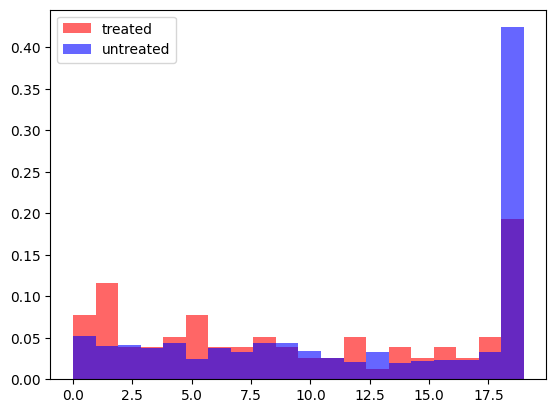

In [172]:
fig, ax = plt.subplots()
_, bin_edges = np.histogram(data.groupby('subject_id').time.max(), bins=20)
ax.hist(data[data.A==1].groupby('subject_id').time.max(), label='treated', 
        color='r', alpha=.6, density=True, bins=bin_edges)
ax.hist(data[data.A==0].groupby('subject_id').time.max(), label='untreated', 
        color='b', alpha=.6, density=True, bins=bin_edges)
ax.legend()